#### Loads

In [1]:
import pandas as pd
from DeepRetail.forecasting.statistical import StatisticalForecaster
from DeepRetail.exploratory.eda import get_features
from matplotlib import pyplot as plt
from DeepRetail.evaluation.base import Evaluator
# Import metrics for evaluation
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape
from DeepRetail.exploratory.eda import get_features
from DeepRetail.transformations.formats import MinMaxScaler_custom
from DeepRetail.forecasting.ml import GlobalForecaster
import lightgbm as lgb
import numpy as np

from DeepRetail.reconciliation.temporal import THieF, TemporalReconciler
from DeepRetail.reconciliation.utils import get_factors
from DeepRetail.reconciliation.cross_sectional import CHieF, CrossSectionalReconciler
from DeepRetail.transformations.formats import hierarchical_to_transaction, extract_hierarchical_structure
from DeepRetail.reconciliation.cross_temporal import CrossTemporalReconciler, C_THieF

/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Define metrics
metrics = [rmsse, scaled_error, mape]

In [3]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/motors_month.csv', index_col=0)
df.head()

,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,...,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30
unique_id,,,,,,,,,,,,,,,,,,,,,
Audi A1,2.0,21.0,9.0,3.0,5.0,2.0,2.0,1.0,1.0,1.0,...,2.0,0.0,3.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0
Audi A3,6.0,45.0,20.0,23.0,13.0,11.0,8.0,9.0,7.0,13.0,...,11.0,6.0,6.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0
Audi A4,15.0,60.0,29.0,26.0,16.0,26.0,17.0,13.0,7.0,14.0,...,8.0,2.0,6.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0
Audi A5,2.0,11.0,8.0,5.0,4.0,4.0,7.0,7.0,1.0,3.0,...,2.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
Audi A6,6.0,30.0,8.0,9.0,5.0,8.0,11.0,3.0,4.0,5.0,...,1.0,6.0,8.0,4.0,2.0,0.0,3.0,1.0,2.0,0.0


In [4]:
# convert columns to datetime
df.columns = pd.to_datetime(df.columns)

# Drop columns with only nans
df = df.dropna(axis = 0, how = 'all')
df = df.fillna(0)

# Drop rows with only zeros
df = df.loc[~(df==0).all(axis=1)]

# Drop the last month cuz its incomplete
df = df.drop(df.columns[-1], axis = 1)

In [5]:
# Count non zero observations per row on df
non_zero_obs = df.astype(bool).sum(axis=1)

# Total series with over 5 non zero observations
print(len(non_zero_obs))
len(non_zero_obs[non_zero_obs > 5])

83


69

##### Split Data for the two Experiments

In [6]:
# Filter df to only include series with over 5 non zero observations
sample_df = df.loc[non_zero_obs[non_zero_obs > 5].index]
sample_df.shape

(69, 64)

In [7]:
# Will also consider the sample I used on my first experiment.
# The assumption there was that in order to forecast 9 months ahead (6 + 4 cv)
# We would need at least 13 observations

# Count the number of observations and the trailing zeros
obs_count = pd.DataFrame(df.shape[1] - df.isin([0]).sum(axis=1)).rename(columns = {0:'Total_Observations'})
obs_count['Trailing_Zeros'] = df.iloc[:,-9:].isin([0]).sum(axis=1)

# Keep only series with at least 12 non zero observations
observation_threshold = 18
total_vals = 9

# We also do not want all observatios at the end to be zeros!
obs_count_f = obs_count[(obs_count['Total_Observations'] > observation_threshold + total_vals) &  (obs_count['Trailing_Zeros'] < 9)]

# Threshold will be 30
#obs_count_f = obs_count_f[obs_count_f['Total_Observations'] >= 30 ]

# Filtering the df
ids = obs_count_f.reset_index()['unique_id'].unique()

sample_df_2 = df.loc[ids]
sample_df_2.shape # half from the other sample df

(42, 64)

#### Basic EDA

In [8]:
features = get_features(sample_df, seasonal_period = 12, periods = 12)
# Use thecustom minmax scaler to normalize lumpiness into 0-1
features['lumpiness'] = MinMaxScaler_custom(features['lumpiness'], feature_range=(0, 1))
features['linearity'] = MinMaxScaler_custom(features['linearity'], feature_range=(0, 1))
features

,unique_id,lumpiness,entropy,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough,Residual_CoV
0,Audi A1,0.168521,0.843299,1,12,0.368295,0.000059,0.295005,-2.106874,0.171413,0.264093,0.711022,2,8,0.904100
1,Audi A3,0.094663,0.863231,1,12,0.560638,0.000027,0.246995,-2.089089,0.159470,0.130431,0.681381,2,1,0.977620
2,Audi A4,0.059194,0.840189,1,12,0.621546,0.000019,0.109561,-1.937322,0.089529,0.133333,0.697532,2,9,0.973570
3,Audi A5,0.080928,0.843849,1,12,0.558468,0.000081,0.165464,-3.726647,-0.069252,0.169236,0.581043,2,9,0.943433
4,Audi A6,0.022619,0.765659,1,12,0.760987,0.000014,0.343210,-4.464234,0.080095,0.204122,0.756666,2,6,0.989713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Volkswagen T-Roc,0.094369,0.793258,1,12,0.605491,0.000061,0.584185,-3.858781,0.036441,0.080484,0.729964,2,8,0.896484
65,Volkswagen Tiguan,0.000000,0.748458,1,12,0.651918,0.000004,0.270083,-2.216617,0.197016,0.209483,0.900904,2,9,0.988531
66,Volkswagen Touareg,0.214757,0.874884,1,12,0.213035,0.000146,0.460344,-2.030580,0.049796,0.412146,0.459178,2,12,0.577585
67,Volkswagen Touran,0.147734,0.845859,1,12,0.615687,0.000018,0.109597,-0.733032,0.060871,0.192862,0.831769,2,1,0.948189


In [9]:
# Lumpiness -> the variability of the variability of the series

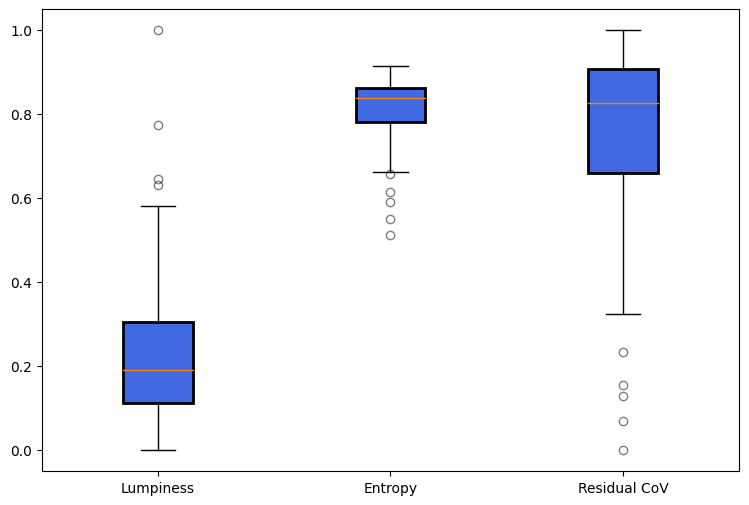

In [10]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['lumpiness'], features['entropy'], features['Residual_CoV']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['Lumpiness', 'Entropy', 'Residual CoV'])

plt.show()

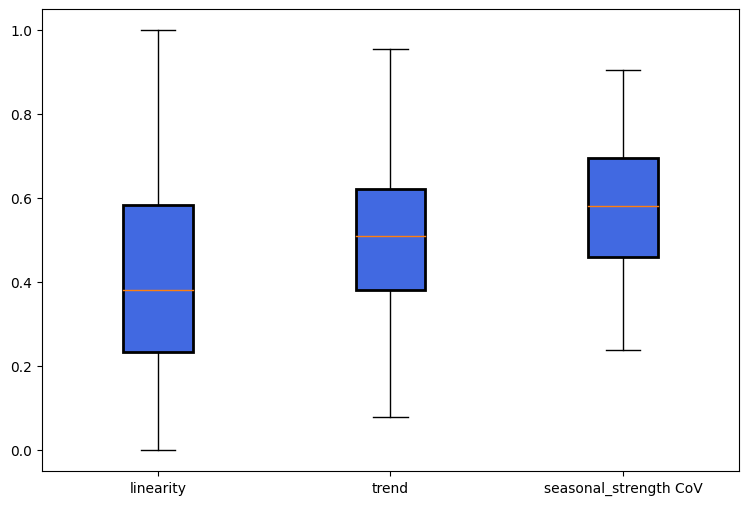

In [11]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['linearity'], features['trend'], features['seasonal_strength']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['linearity', 'trend', 'seasonal_strength CoV'])

plt.show()

#### Statistical Forecaster

In [12]:
# Define some parameters
freq = 'M'
holdout = True
h = 6
cv = 4
models = ['ETS', 'Naive', 'SNaive', 'CrostonOptimized']

In [13]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq, distributed=True, n_partitions=10)

# Fit the forecaster
forecaster.fit(sample_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

2023-04-05 17:31:13,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3dtspteg', purging
2023-04-05 17:31:13,602 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-nvvt_4pc', purging
2023-04-05 17:31:13,603 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c1uspb7l', purging
2023-04-05 17:31:13,604 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-r96mcn_8', purging


make fugue


In [14]:
# Evaluate

# Define the evaluator
evaluator = Evaluator(sample_df, forecast_df, freq = freq, format = 'pivoted')
eval_df = evaluator.evaluate(metrics = metrics)

# keep only relevant columns
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
1656,Audi A1,Naive,1,1,1.248075,-0.259615,3.000000
1657,Audi A1,Naive,2,1,1.664101,-0.346154,0.000000
1658,Audi A1,Naive,3,1,1.040063,-0.216346,1.666667
1659,Audi A1,Naive,4,1,1.664101,-0.346154,0.000000
1660,Audi A1,Naive,5,1,1.248075,-0.259615,3.000000
...,...,...,...,...,...,...,...
8275,Skoda Rapid,CrostonOptimized,5,4,0.160427,-0.033371,0.000000
8276,Skoda Rapid,CrostonOptimized,6,4,0.160427,-0.033371,0.000000
8277,Skoda Rapid,CrostonOptimized,7,4,0.160427,-0.033371,0.000000
8278,Skoda Rapid,CrostonOptimized,8,4,0.160427,-0.033371,0.000000


##### EDA on the Results

In [15]:
# merge eval_df with features on the unique
# groupby on time-series and model
eval_df_ = eval_df.groupby(['unique_id', 'Model']).mean().reset_index()

# add the features
eval_df_ = pd.merge(eval_df_, features, left_on = 'unique_id', right_on = 'unique_id', how = 'left')

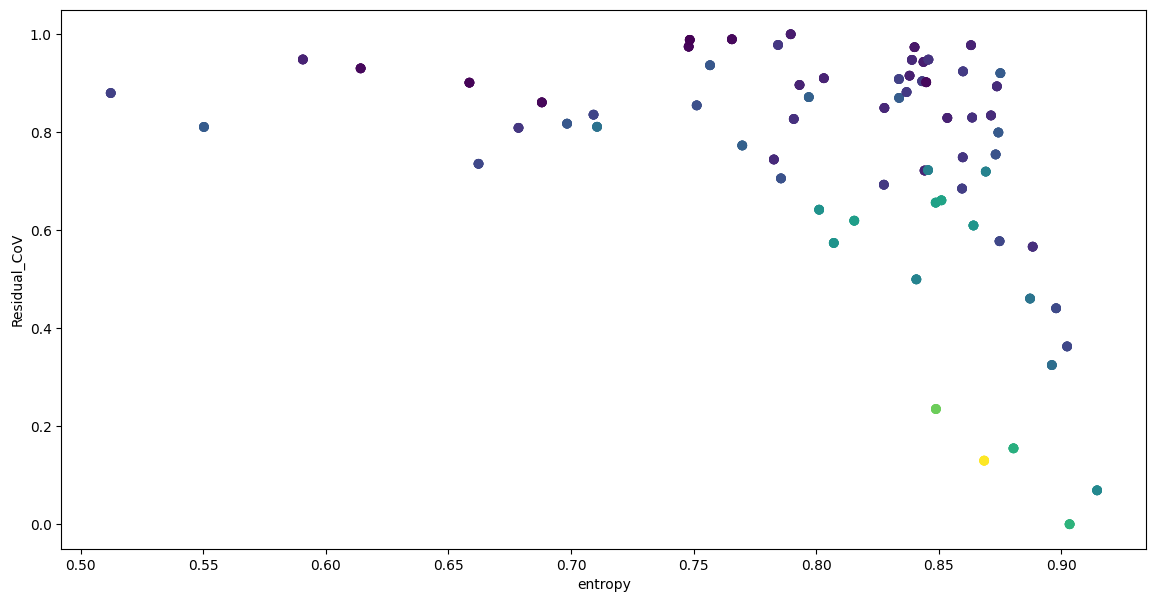

In [16]:
# A scatter plot with entropy on x and Residual_CoV on y 

plt.figure(figsize = (14,7))
plt.scatter(eval_df_['entropy'], eval_df_['Residual_CoV'], c = eval_df_['lumpiness'])

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')
plt.show()



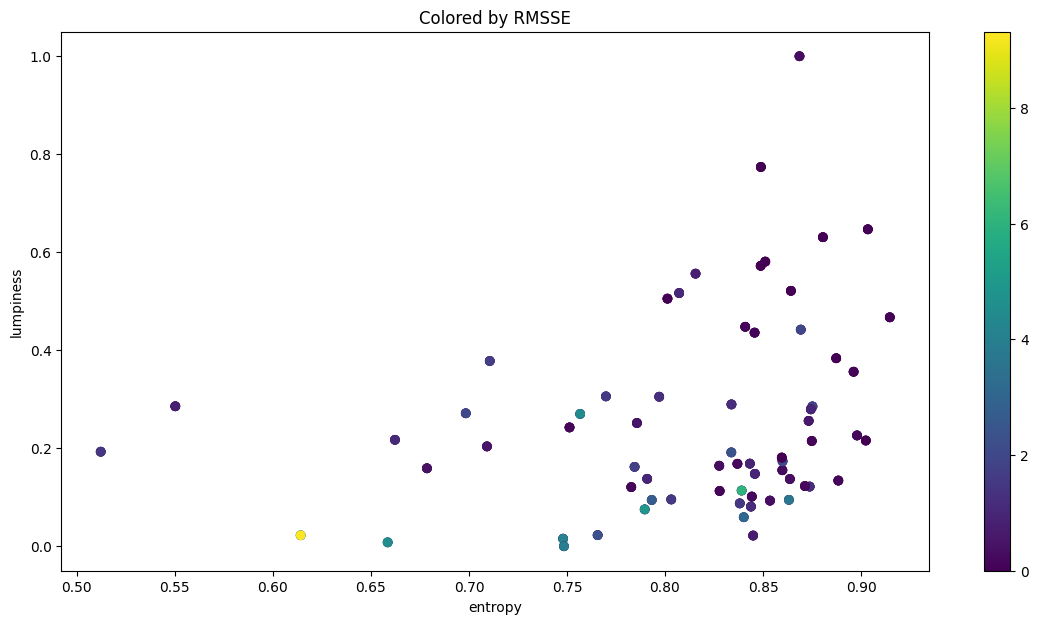

In [17]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['lumpiness'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('lumpiness')
plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

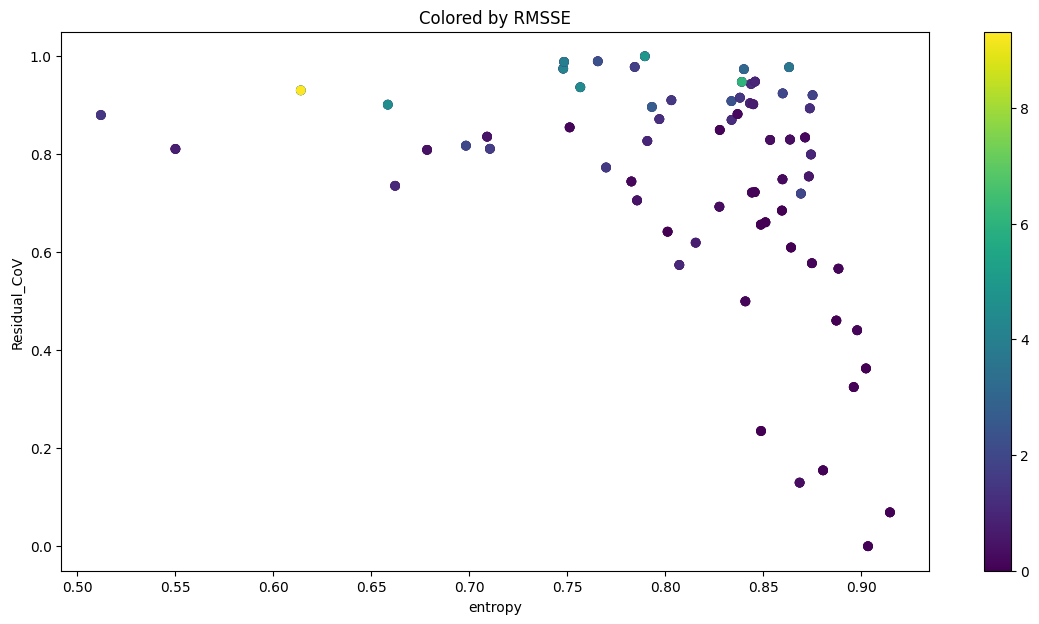

In [18]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['Residual_CoV'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')

plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

#### LGBM Forecaster

In [19]:
# Define features and transformations 

# Best lag is 11 -> I have already tried
features = {'lags': 19}
transformations = {'normalize': 'StandardScaler'}

# Define model specific
loss_f = 'mae' # Default selection
random_state = 42
model = lgb.LGBMRegressor(objective = loss_f, random_state = random_state, use_missing = True)
model_name = 'lgbm'

In [20]:
lgbm_forecaster = GlobalForecaster(model = model ,
                                    features = features, 
                                    transformations = transformations,
                                    model_name =  model_name)
# Fit 
lgbm_forecaster.fit(sample_df)

# Predict
global_fc = lgbm_forecaster.predict(h = h, cv = cv)

In [21]:
# Define the evaluator
evaluator = Evaluator(sample_df, global_fc, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
1656,Audi A1,Naive,1,1,1.248075,-0.259615,3.000000
1657,Audi A1,Naive,2,1,1.664101,-0.346154,0.000000
1658,Audi A1,Naive,3,1,1.040063,-0.216346,1.666667
1659,Audi A1,Naive,4,1,1.664101,-0.346154,0.000000
1660,Audi A1,Naive,5,1,1.248075,-0.259615,3.000000
...,...,...,...,...,...,...,...
1651,Volkswagen Up,lgbm,2,4,0.006077,-0.001264,0.000000
1652,Volkswagen Up,lgbm,3,4,0.144533,0.030065,0.694826
1653,Volkswagen Up,lgbm,4,4,0.172923,0.035970,0.831313
1654,Volkswagen Up,lgbm,5,4,0.008657,-0.001801,0.000000


#### Temporal Hierarchies

In [22]:
factors = get_factors(freq = h) # 6 months total -> so factors of 6
factors

array([1, 2, 3, 6])

In [23]:
# Starting with Naive
model = 'Naive'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_naive = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])


In [24]:
# Next with ETS
model = 'ETS'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_ets = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [25]:
# Next with ETS
model = 'CrostonOptimized'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_croston = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [26]:
# Base forecast combinations

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [27]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_mean)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [28]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_median)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Sectional

In [40]:
# Initialize Arguments
current = ['Model', 'Brand']
correct = ['Brand', 'Model']
splitter = ' '
total = True

In [44]:
# Start with Naive
model = 'Naive'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_naive = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'Model']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [45]:
# Start with Naive
model = 'ETS'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_ets = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'Model']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [46]:
# Start with Naive
model = 'CrostonOptimized'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_croston = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'Model']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [47]:
# Base forecast combinations

# Extend forecasts to include the hierarchical level
base_forecasts_naive = hierarchical_to_transaction(base_forecasts_naive, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_ets = hierarchical_to_transaction(base_forecasts_ets, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_croston = hierarchical_to_transaction(base_forecasts_croston, chief.hierarchical_format, sort_by = False, format = 'transaction')


# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'True':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'True_first': 'True', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'True', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'True', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

base_forecasts_combined_median

,unique_id,cross_sectional_level,fh,cv,y,True,date,Model
0,T,total,1,1,428.524323,361.0,2021-07-31,Median_Combination
1,T,total,2,1,428.524323,349.0,2021-08-31,Median_Combination
2,T,total,2,2,361.000000,349.0,2021-08-31,Median_Combination
3,T,total,3,1,428.524323,495.0,2021-09-30,Median_Combination
4,T,total,3,2,400.727173,495.0,2021-09-30,Median_Combination
...,...,...,...,...,...,...,...,...
1795,T_Volkswagen_Up,Brand,7,3,0.986559,1.0,2022-01-31,Median_Combination
1796,T_Volkswagen_Up,Brand,7,4,0.729843,1.0,2022-01-31,Median_Combination
1797,T_Volkswagen_Up,Brand,8,3,0.986559,0.0,2022-02-28,Median_Combination
1798,T_Volkswagen_Up,Brand,8,4,0.729843,0.0,2022-02-28,Median_Combination


In [48]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_median, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'Model']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [49]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_mean, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'Model']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Temporal

In [50]:
# Start with Naive
models = 'Naive'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_naive = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'Model') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Naive'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [51]:
# Start with Naive
models = 'ETS'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_ets = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'Model') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-ETS'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [52]:
# Start with Naive
models = 'CrostonOptimized'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_croston = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'Model') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-CrostonOptimized'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [53]:
# Base forecast combinations
# Change some types
base_forecasts_naive['cross_sectional_level'] = base_forecasts_naive['cross_sectional_level'].astype(str)
base_forecasts_ets['cross_sectional_level'] = base_forecasts_ets['cross_sectional_level'].astype(str)
base_forecasts_croston['cross_sectional_level'] = base_forecasts_croston['cross_sectional_level'].astype(str)

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [54]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_median, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'Model') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Median_Combination'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [55]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_mean, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'Model') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Mean_Combination'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Analyze Results

In [56]:
# Drop any duplicates
eval_df = eval_df.drop_duplicates(subset = ['unique_id', 'Model', 'fh', 'cv'])

In [57]:
# Best model
eval_df.groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
3,CTR-struc-Mean_Combination,0.266341,0.001613,0.251962
4,CTR-struc-Median_Combination,0.300844,0.002144,0.261215
1,CTR-struc-CrostonOptimized,0.319120,0.002004,0.272910
9,HR-struc-Mean_Combination,0.262433,0.000604,0.295517
5,CTR-struc-Naive,0.340333,0.001194,0.312656
10,HR-struc-Median_Combination,0.307696,0.001358,0.313157
8,HR-struc-CrostonOptimized,0.326884,0.001105,0.320906
11,HR-struc-Naive,0.363103,0.001529,0.367415
7,HR-struc-AutoETS,0.348137,-0.000821,0.380686
2,CTR-struc-ETS,0.372277,0.001641,0.384335


In [58]:
# Best model no outliers
eval_df[eval_df['rmsse'] < 10].groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
3,CTR-struc-Mean_Combination,0.266341,0.001613,0.251962
4,CTR-struc-Median_Combination,0.300844,0.002144,0.261215
1,CTR-struc-CrostonOptimized,0.319120,0.002004,0.272910
9,HR-struc-Mean_Combination,0.262433,0.000604,0.295517
5,CTR-struc-Naive,0.340333,0.001194,0.312656
10,HR-struc-Median_Combination,0.307696,0.001358,0.313157
8,HR-struc-CrostonOptimized,0.326884,0.001105,0.320906
11,HR-struc-Naive,0.363103,0.001529,0.367415
7,HR-struc-AutoETS,0.348137,-0.000821,0.380686
2,CTR-struc-ETS,0.372277,0.001641,0.384335


In [59]:
import seaborn as sns

In [60]:
def classify_techniques(model):
    if 'CTR' in model:
        out = 'Cross_Temporal'
    elif 'TR' in model:
        out = 'Temporal'
    elif 'HR' in model:
        out = 'Cross_Sectional'
    else:
        out = 'Base'
    return out

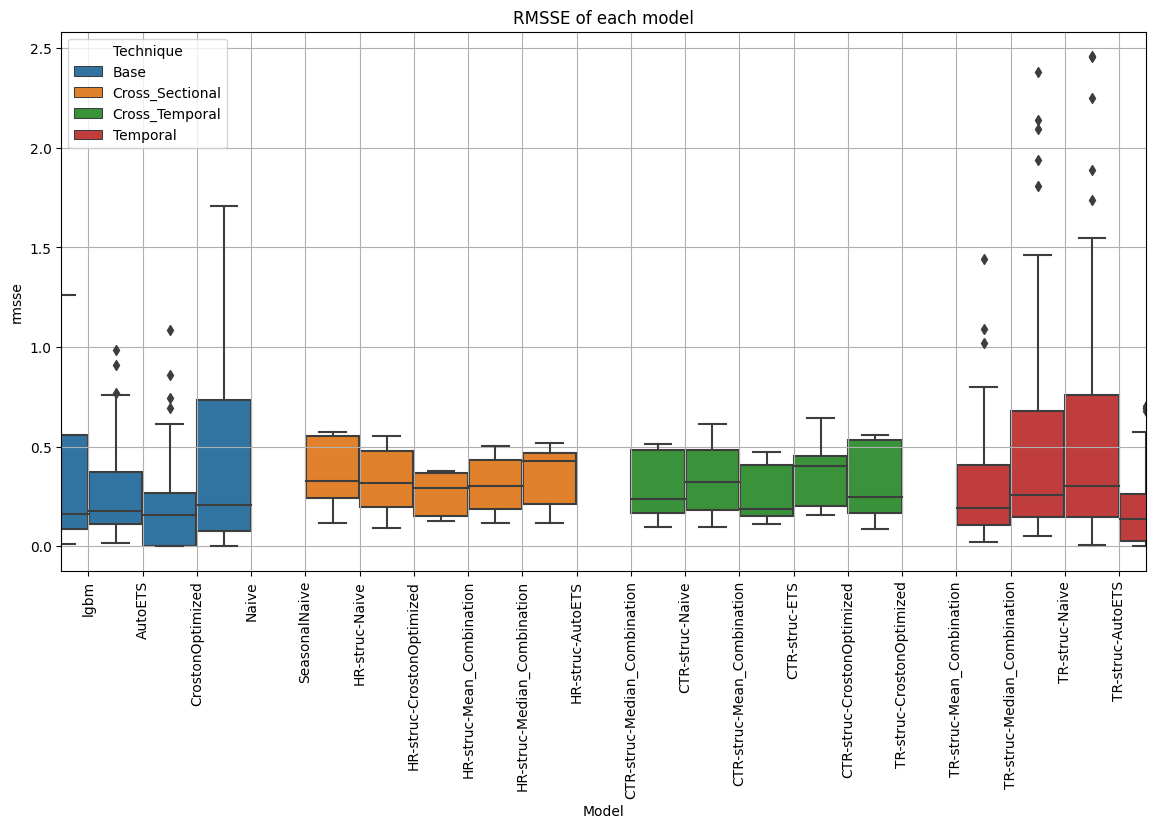

In [61]:
# remove out
remove_out = True
total_outliers = 25

eval_df_group = eval_df.groupby(['unique_id','Model']).mean().reset_index().drop('cv', axis = 1)
# classify techniques
eval_df_group['Technique'] = eval_df_group['Model'].apply(classify_techniques)

# find the outlier series
# mean rmsse over 50
outliers = eval_df_group.groupby(['unique_id']).mean().reset_index().sort_values('rmsse', ascending = False).head(total_outliers)['unique_id'].values

if remove_out:
    eval_df_group = eval_df_group[~eval_df_group['unique_id'].isin(outliers)]

# Remove outlier mapes
#eval_df_group = eval_df_group[eval_df_group['rmsse'] < 10]

# A boxplot for the rmsse of each model on the eval_df_group df
# Models should be grouped based on the Technique

# Sort the dataframe based on the technique
eval_df_group = eval_df_group.sort_values('Technique')

# Figure
fig, ax = plt.subplots(figsize = (14, 7))

# Boxplots, color should be based on the technique
# Distance and width should be adjusted
sns.boxplot(x = 'Model', y = 'rmsse', data = eval_df_group, ax = ax, hue = 'Technique', width = 4)

ax.grid()

ax.set_title('RMSSE of each model')

ax.set_xlabel('Model')

ax.set_ylabel('rmsse')

plt.xticks(rotation = 90)

plt.show()

